# Project 1: Population & Food Supply

In [1]:
# %pip install wbdata
# %pip install pandas
# %pip install plotly
# %pip install geopandas
# %pip install matplotlib

import matplotlib.pyplot as plt
import statistics
import geopandas as gpd
import wbdata
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
from datetime import datetime
import numpy as np
import warnings
import plotly.express as px

import warnings
warnings.simplefilter("ignore")

### Population Statistics Function

Credit: our code for this section was inspired by the John Graunt example group.

In [2]:
countries = wbdata.get_countries()
country_dict = {}

# Iterate over the WBSearchResult object, Create Dictionary.
# This dictionary is necessary so that we know which country
# names map to which 3-letter country codes.
for country in countries:
    country_code = country['id']
    country_name = country['name']

    # Add to the dictionary the country name.
    country_dict[country_name] = country_code

def int_to_str(num):
    """Convert the integer to the proper format."""
    if 0 <= num < 10:
        # Add a '0' prefix if it is a single digit.
        return f"0{num}"
    else:
        # Convert to string directly if it is a two-digit number.
        return str(num)

def population_range(year, sex, age_range, place):
    """This function will return the population for a certain age range."""
    sex_codes = {"people": "", "females": "FE", "males": "MA"}
    sex_used = sex_codes[sex]

    # Getting the lower and upper bounds for date into correct format.
    lower, upper = int_to_str(age_range[0]), int_to_str(age_range[1])
    range_string = lower + upper

    # Getting the country code via the name.
    country_code = country_dict.get(place)

    df = wbdata.get_dataframe({"SP.POP." + range_string + "." + sex_used: "Population"},
                              country= {country_code: place}).squeeze()
    df = df.to_frame().reset_index()
    population_total = int(df[df["date"] == str(year)]["Population"].iloc[0])
    return population_total

# function to return the population for people over 80
def over_80_pop(year, sex, place):
    sex_codes = {"people": "", "females": "FE", "males": "MA"}
    sex_used = sex_codes[sex]
    country_code = country_dict.get(place)

    df = wbdata.get_dataframe({"SP.POP." + "80UP" + "." + sex_used: "Population"},
                              country= {country_code: place}).squeeze()
    df = df.to_frame().reset_index()
    population_total = int(df[df["date"] == str(year)]["Population"].iloc[0])
    return population_total


def dict_helper(year, sex, age_range, place):
    """This will expand our function to include every age specified possible."""
    if len(age_range) == 1:
        age_range = [age_range[0], age_range[0]]
    elif age_range[1] < age_range[0]:
      raise ValueError(f"Please ensure that the second value in the range is greater than the first.")

    minimum_age, maximum_age = age_range
    possible_minimums = [i for i in range(0, 76, 5)]
    possible_maximums = [i for i in range(4, 80, 5)]

    my_dict = {}
    for age in range(minimum_age, maximum_age + 1):
        """Find the index in the possible ranges that includes the current age."""
        range_index = next((i for i, min_val in enumerate(possible_minimums) if
                            min_val <= age and age <= possible_maximums[i]), None)
        if range_index is not None:
            popl_value = population_range(year, sex, [possible_minimums[range_index], possible_maximums[range_index]], place) // 5
            my_dict[age] = popl_value
        elif age >= 80 and age <= 100:
            my_dict[age] = over_80_pop(year, sex, place) / 20
        else:
            raise ValueError(f"No age range available for age {age}")

    return my_dict


def population(year, sex, age_range, place):
    """This function ties everything together, returning population for given age ranges.
    During usage, please utilize the following format:
    Arguments to Use:
    Year (int): the specified year, works from 1960-2021.
    Sex (string): Anything from all, people, p, P, People, All, Everyone, female, females, f, Female, 
                Females, F, FE, male, males, m, Male, Males, M, MA works.
    Age Range (list with length 2, 2 integers): A list of the age bounds.
    Place (string): A string of the specified location.
    """
    if place not in country_dict:
        valid_regions = ", ".join(country_dict.keys())
        raise ValueError(f"The region '{place}' is not valid. Please choose from the following regions: {valid_regions}")
    if sex in ["all", "people", "p", "P", "People", "All", "Everyone"]:
      female_dict = dict_helper(year, "females", age_range, place)
      male_dict = dict_helper(year, "males", age_range, place)
      return sum(female_dict.values()) + sum(male_dict.values())
    elif sex in ["female", "females", "f", "Female", "Females", "F", "FE"]:
      female_dict = dict_helper(year, "females", age_range, place)
      return sum(female_dict.values())
    elif sex in ["male", "males", "m", "Male", "Males", "M", "MA"]:
      male_dict = dict_helper(year, "males", age_range, place)
      return sum(male_dict.values())
        
population(2023, "People", [5, 7], "Haiti")

736914

In [3]:
population(2022, "people", [0,100], "World")

7997756448.5

In [4]:
population(2023, "people", [0,100], "Haiti")

11640516.0

### Popualtion Dataframe

Credit: our code was based off the John Graunt group's example.

In [5]:
def create_population_dataframe(regions, years, age_range):
    """Creates the population DataFrame based on the regions, years, and age ranges wanted.
    During usage, please utilize the following format:
    Arguments to Use:
    regions (list of strings, any length): the specified year, works from 1960-2022.
    years (list of ints, any length): Anything from all, people, p, P, People, All, Everyone, female, females, f, Female, 
                Females, F, FE, male, males, m, Male, Males, M, MA works.
    age_range (list of two ints): the age bounds specified, second must be greater than the first.
    """
    data = []

    # Check if age_range is a single age or a range.
    if len(age_range) == 1:
        full_age_range = [age_range[0]]
    else:
        full_age_range = list(range(age_range[0], age_range[1] + 1))

    # Iterate over each region, year, and age."
    for region in regions:
        for year in years:
            row = {'Region': region, 'Year': year}
            for age in full_age_range:
                male_population = population(year, 'male', [age], region)
                female_population = population(year, 'female', [age], region)
                total_population = male_population + female_population

                row[f'Male Population Age {age}'] = male_population
                row[f'Female Population Age {age}'] = female_population
                row[f'Total Population Age {age}'] = total_population

            data.append(row)

    # Create a DataFrame.
    df = pd.DataFrame(data)

    # Set the index.
    df.set_index(['Region', 'Year'], inplace=True)

    return df

In [6]:
population_df = create_population_dataframe(["Haiti"], [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2023], [0, 80])
population_df

Male Population Age 0  Female Population Age 0  \
Region Year                                                   
Haiti  1990                 110694                   109899   
       1991                 112761                   111911   
       1992                 114464                   113556   
       1993                 115758                   114788   
       1994                 116666                   115632   
       1995                 117289                   116189   
       1996                 117784                   116624   
       1997                 118296                   117073   
       1998                 118836                   117550   
       1999                 119400                   118068   
       2000                 120093                   118714   
       2001                 120750                   119312   
       2002                 121165                   119669   
       2003                 121539                   119966   
       2004                 121811                   120120   
       2005                 121932                   120105   
       2006                 122259                   120287   
       2007                 122914                   120782   
       2008                 123731                   121444   
       2009                 124681                   122269   
       2010                 124861                   122356   
       2011                 124937                   122388   
       2012                 125615                   123072   
       2023                 124824                   122286   

             Total Population Age 0  Male Population Age 1  \
Region Year                                                  
Haiti  1990                  220593                 110694   
       1991                  224672                 112761   
       1992                  228020                 114464   
       1993                  230546                 115758   
       1994                  232298                 116666   
       1995                  233478                 117289   
       1996                  234408                 117784   
       1997                  235369                 118296   
       1998                  236386                 118836   
       1999                  237468                 119400   
       2000                  238807                 120093   
       2001                  240062                 120750   
       2002                  240834                 121165   
       2003                  241505                 121539   
       2004                  241931                 121811   
       2005                  242037                 121932   
       2006                  242546                 122259   
       2007                  243696                 122914   
       2008                  245175                 123731   
       2009                  246950                 124681   
       2010                  247217                 124861   
       2011                  247325                 124937   
       2012                  248687                 125615   
       2023                  247110                 124824   

             Female Population Age 1  Total Population Age 1  \
Region Year                                                    
Haiti  1990                   109899                  220593   
       1991                   111911                  224672   
       1992                   113556                  228020   
       1993                   114788                  230546   
       1994                   115632                  232298   
       1995                   116189                  233478   
       1996                   116624                  234408   
       1997                   117073                  235369   
       1998                   117550                  236386   
       1999                   118068                  237

# Unit Tests

In [7]:
# This unit test verifies that there were more females than males in the Jamaica aged between 60-80 in the year 2010.

assert(population(2010, "males", [60, 80], "Jamaica") < population(2010, "females", [60, 80], "Jamaica")), "Error"


In [8]:
# This unit test verifies that there were more than 50,000 Moroccon residents between the ages of 20-50 in the year 2020.

assert(population(2020, "all", [20, 50], "Morocco") > 50000), "Error"


In [9]:
# This unit test verifies that there were more Chinese residents between the ages 40-59 than the ages 60-79 in the year 1990

assert(population(1990, "all", [40, 59], "China") > population(1990, "all", [60, 79], "China")), "Error"


TypeError: 'NoneType' object does not support item deletion

In [10]:
# This unit test verifies that there were more Lebanese residents between the ages 30-50 in the year 2019 than in the year 2020.

assert(population(2019, "all", [30, 50], "Lebanon") > population(2020, "all", [30, 50], "Lebanon")), "Error"

TypeError: 'NoneType' object does not support item deletion

In [11]:
# This unit test verifies that there were more Canadian residents between the ages 5-15 than the ages 60-79 in the year 1990

assert(population(1990, "all", [5, 15], "Canada") > population(1990, "all", [60, 79], "Canada")), "Error"

TypeError: 'NoneType' object does not support item deletion

# Population Pyramids

In [12]:
def population_pyramid(df, year, region):
    """Plots a population pyramid for a given year and region. Parameters:
    - df (pd.DataFrame): Population data with columns for male and female population by age
    - year (int): The year for which the pyramid should be plotted
    - region (str): The region to visualize
    """
    # Extract data for the given year and region
    try:
        data = df.loc[(region, year)]
    except KeyError:
        raise ValueError(f"No data available for {region} in {year}.")
    
    # Extract age groups
    age_groups = sorted(set(int(col.split()[-1]) for col in df.columns if 'Population Age' in col))
    
    # Retrieve male and female population counts
    male_counts = [-data[f'Male Population Age {age}'] for age in age_groups]  # Negative for left-side visualization
    female_counts = [data[f'Female Population Age {age}'] for age in age_groups]

    # Create the figure
    fig = go.Figure()

    fig.add_trace(go.Bar(y=age_groups, x=male_counts, name='Males', orientation='h', marker=dict(color='blue')))

    fig.add_trace(go.Bar(y=age_groups, x=female_counts, name='Females', orientation='h', marker=dict(color='red')))

    # Customize layout
    fig.update_layout(title=f'Population Pyramid for {region} in {year}', xaxis=dict(title='Population', tickformat=',d'), yaxis=dict(title='Age'), barmode='relative', bargap=0.1, bargroupgap=0)

    # Show the plot
    fig.show()

In [13]:
population_pyramid(population_df, 2010, "Haiti")

In [14]:
def animated_population_pyramid(df, region):
    """Creates an animated population pyramid for a given region with male and female population data over 5-year intervals. Parameters:
    - df (pd.DataFrame): Population data with male and female counts by age-sex groups for each year
    - region (str): The region to visualize
    """
    # Extract years from the DataFrame index, and filter for every 5 years
    years = [year for year in range(1990, 2021, 5) if year in df.index.get_level_values(1).unique()]
    
    # Initialize a list for the traces (bars) to be added to the plot
    traces = []

    # Iterate through each year and add the population pyramid for each
    for year in years:
        try:
            # Debugging: Check if data exists for the region and year
            print(f"Retrieving data for {region} in {year}...")
            data = df.loc[(region, year)]  # Get the population data for this year
            
            # Extract age groups 
            age_groups = sorted(set(int(col.split()[-1]) for col in df.columns if 'Population Age' in col))

            # Retrieve male and female population counts for this year
            male_counts = [-data[f'Male Population Age {age}'] for age in age_groups]  
            female_counts = [data[f'Female Population Age {age}'] for age in age_groups]

            # Add Male trace for this year
            traces.append(go.Bar(x=male_counts, y=age_groups, orientation='h', name=f'Men {year}', hoverinfo='skip',opacity=0.7))

            # Add Female trace for this year
            traces.append(go.Bar(x=female_counts, y=age_groups, orientation='h', name=f'Women {year}', hoverinfo='skip', opacity=0.7))

        except KeyError:
            print(f"No data found for {region} in {year}")

    # Create the layout for the plot
    layout = go.Layout(title=f"Population Pyramid for {region}", xaxis=dict(title="Population", tickformat=',d'), yaxis=dict(title="Age Group"), barmode='overlay', bargap=0.1, bargroupgap=0,
                       legend=dict(x=1.05, y=1, traceorder='normal', font=dict(size=12), bgcolor='rgba(255, 255, 255, 0.7)', bordercolor='Black', borderwidth=1))

    # If there are traces to plot, create the figure
    if traces:
        fig = go.Figure(data=traces, layout=layout)
        fig.show()
    else:
        print(f"No data to display for {region}")

In [15]:
animated_population_pyramid(population_df, "Haiti")

Retrieving data for Haiti in 1990...
Retrieving data for Haiti in 1995...
Retrieving data for Haiti in 2000...
Retrieving data for Haiti in 2005...
Retrieving data for Haiti in 2010...


# Population Maps

### Topography of Hispaniola 


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


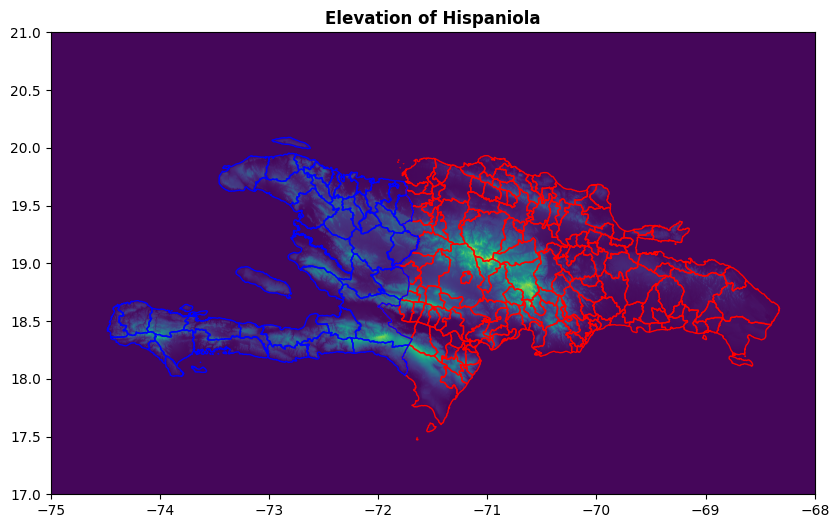

In [11]:
%pip install rasterio

from matplotlib.pyplot import show
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import geopandas as gpd

boundary_dom = gpd.read_file("gadm41_DOM_2.json")


boundary_hti = gpd.read_file("gadm41_HTI_2.json")


fig, ax = plt.subplots(figsize=(10, 6))
topography_data = rasterio.open('hgt_files/mosaic_srtm.tif')

rasterio.plot.show(
    source=topography_data,
    ax=ax,
    cmap='viridis',
    title = "Elevation of Hispaniola"
)


# -- Now overlay the boundaries
boundary_dom.plot(ax=ax, facecolor='none', edgecolor='red',  linewidth=1)
boundary_hti.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

plt.show()

# Other Visualizations

**Mortality Rate**

In [16]:
pd.options.plotting.backend = 'plotly'

indicators = {"SP.DYN.AMRT.MA": "Mortality rate, adult, male (per 1,000 male adults)",
              "SP.DYN.AMRT.FE": "Mortality rate, adult, female (per 1,000 female adults)"}

data = wbdata.get_dataframe(indicators, country="HTI", parse_dates=True)
fig = data.plot(title="Mortality Rate (per 1,000 adults)")
fig.for_each_trace(lambda t: t.update(name="Males") if t.name == indicators["SP.DYN.AMRT.MA"] else t.update(name="Females"))
fig.show()

TypeError: 'NoneType' object does not support item deletion

**Crude Death Rate**

In [17]:
cdr_ind = {"SP.DYN.CDRT.IN":"Death rate, crude (per 1,000 people)"}

data = wbdata.get_dataframe(cdr_ind, country="HTI", parse_dates=True)
fig = data.plot(title="Death Rate (per 1,000 adults)", labels=dict(date='Year', value='Rate'))
fig.update_layout(showlegend=False)
fig.show()

**Agricultural Land**

In [18]:
indicator1 = {"AG.LND.AGRI.ZS":"Agricultural land (% of land area)"}

data = wbdata.get_dataframe(indicator1, country="HTI", parse_dates=True)
fig = data.plot(title="Agricultural Land Percentage", labels=dict(date='Year',value='% of Land Area'))
fig.update_layout(showlegend=False)
fig.show()

TypeError: 'NoneType' object does not support item deletion

Agriculture Output and Factor Development (load on Datahub)

In [12]:

# %pip install python_gnupg
# %pip install -U gspread_pandas

from functools import cache
import pandas as pd
import numpy as np

pd.options.plotting.backend = 'plotly'

@cache
def get_ag_data():
    """Read a bunch of google worksheets into a dictionary of dataframes"""
    data = pd.read_csv('wide_class_data.csv')

    Data = {'Country':'Country/territory','WDI Code':'ISO3','Year':'Year','Output':'Outall_Index','TFP':'TFP_Index','Land':'Land_Index','Labor':'Labor_Index','Capital':'Capital_Index','Materials':'Materials_Index'}

    df = data.rename(columns={v:k for k,v in Data.items()})
    df = df[Data.keys()].set_index(['WDI Code','Country','Year'])

    # Deal with some duplicate indices (drops regions)
    df = df.loc[~df.index.duplicated(),:]

    df = df.droplevel('WDI Code')

    return df

In [13]:
df = get_ag_data()
select = df.xs('Haiti',level='Country').dropna(how='any')

dselect = np.log(select).diff()
dselect['Inputs'] = dselect['Output'] - dselect['TFP']

dselect.mean()

select = select/select.loc[1961,:]
select.plot(title='Factor development and Agricultural Output levels since 1961',labels={'value':'Input/Output development', 'date':'year'})
